In [9]:
# https://medium.com/@hirok4/python-implementation-of-ellipse-fitting-e8801dbb16a8

import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(1, '..\\..\\HDF5')
from HDF5 import *


In [10]:
dictionary = load_hdf5_to_dict('..\\amplitrix2_IQMixer.hdf5')

I = np.array(dictionary['p0']['freqs']['f0']['I']).reshape(len(dictionary['p0']['freqs']['f0']['I']))
Q = np.array(dictionary['p0']['freqs']['f0']['Q']).reshape(len(dictionary['p0']['freqs']['f0']['Q']))

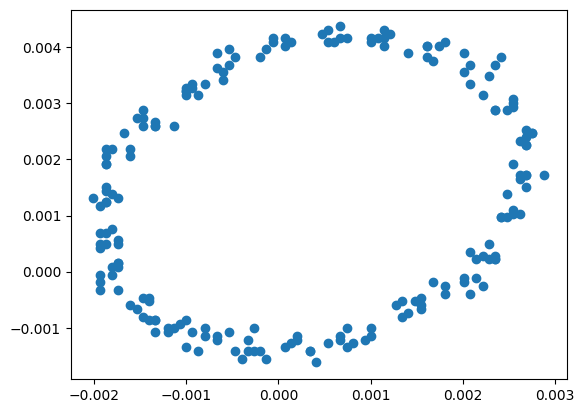

In [11]:
# Plot the noisy data
cln_pts = 30                # clean points for I-Q plane
I =  I[cln_pts:-cln_pts]
Q =  Q[cln_pts:-cln_pts]

plt.clf()
plt.scatter(Q,I)
plt.show()

center: 0.000, 0.001
width: 0.003
height: 0.002
phi: 1.171


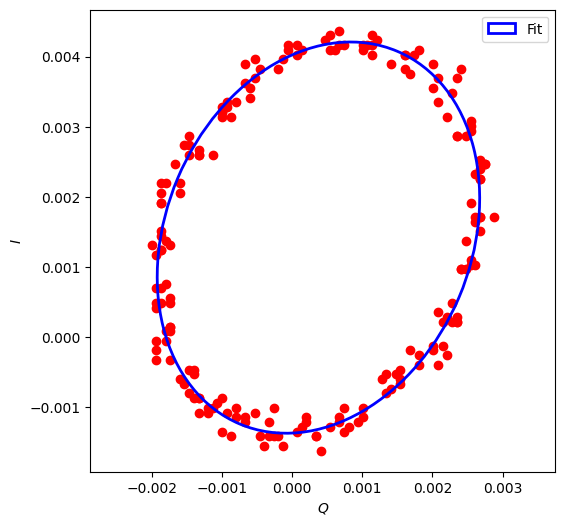

In [15]:
# https://github.com/ehtec/least-squares-ellipse-fitting/blob/master/ellipse.py

import numpy as np
from ellipse import LsqEllipse
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

X = np.array(list(zip(Q, I)))
reg = LsqEllipse().fit(X)
center, width, height, phi = reg.as_parameters()

print(f'center: {center[0]:.3f}, {center[1]:.3f}')
print(f'width: {width:.3f}')
print(f'height: {height:.3f}')
print(f'phi: {phi:.3f}')

fig = plt.figure(figsize=(6, 6))
ax = plt.subplot()
ax.axis('equal')
ax.plot(Q, I, 'ro', zorder=1)
ellipse = Ellipse(
    xy=center, width=2*width, height=2*height, angle=np.rad2deg(phi),
    edgecolor='b', fc='None', lw=2, label='Fit', zorder=2
)
ax.add_patch(ellipse)

plt.xlabel('$Q$')
plt.ylabel('$I$')

plt.legend()
plt.show()

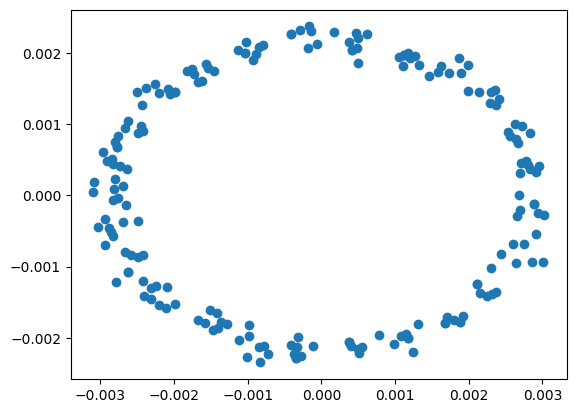

In [18]:
q = Q-center[0]
i = I -center[1]
q_rot = i * np.sin(phi) + q*np.cos(phi)
i_rot = i*np.cos(phi) - q*np.sin(phi)
plt.scatter(q_rot, i_rot)

In [67]:
# Formulate and solve the least squares problem ||Ax - b||^2
A = np.hstack([Q**2, I * Q, I**2, I, Q])
b = np.ones_like(I)
x = np.linalg.lstsq(A, b, rcond=None)[0].squeeze()
print(x)

[ 2.61951777e+05 -8.68677687e+04  1.75975988e+05 -4.61503058e+02
 -7.28867176e+01]


In [62]:
# Print the equation of the ellipse in standard form
center_coor = {
    'xc': x[3]/(2*(x[0]**2-2*x[0]))-x[2]/(4*(x[0]**2-2*x[0]))*((x[4]-(x[3]*x[2])/(2*(x[0]**2-2*x[0])))/(2*(x[1]-(x[2]**2)/(4*(x[0]**2-2*x[0]))))),
    'yc': (x[4]-(x[3]*x[2])/(2*(x[0]**2-2*x[0])))/(2*(x[1]-(x[2]**2)/(4*(x[0]**2-2*x[0]))))
}
a = x[0], 
b = x[1],
c = x[2] * 0.5,
d = 0.5 * (x[3]+2*x[0]*center_coor['xc']+x[2]*center_coor['yc']),
f = 0.5 * (x[4]+2*x[1]*center_coor['yc']+x[2]*center_coor['xc'])

In [63]:
print('Le coordinate del centro sono: C=('+"{:.4f}".format(center_coor['xc'])+','+"{:.4f}".format(center_coor['yc'])+')')

Le coordinate del centro sono: C=(-0.0000,0.0004)


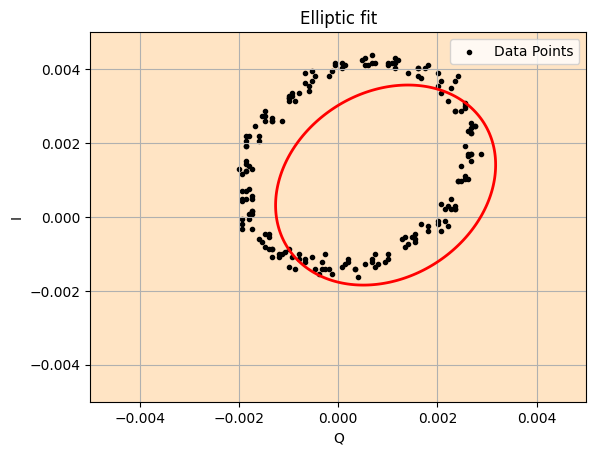

In [64]:
# Plot the least squares ellipse
y_coord = np.linspace(-0.005,0.005,len(I))
x_coord = np.linspace(-0.005,0.005,len(I))
X_coord, Y_coord = np.meshgrid(x_coord, y_coord)
Z_coord = x[0] * (X_coord-center_coor['xc']) ** 2 + x[1] * (X_coord-center_coor['xc']) * (Y_coord-center_coor['yc'])+ x[2] * (Y_coord-center_coor['yc'])**2 + x[3] * (X_coord-center_coor['xc']) + x[4] * (Y_coord-center_coor['yc'])

fig, axs = plt.subplots(1,1)
axs.scatter(Q, I, label='Data Points', marker='.', color='black')
axs.set_facecolor('bisque')
axs.contour(X_coord, Y_coord, Z_coord, levels=[1], colors=('r'), linewidths=2)
axs.legend()
axs.set_title('Elliptic fit')
axs.set_xlabel('Q')
axs.set_ylabel('I')
axs.grid()